In [1]:
import os
import torch
print(torch.cuda.is_available())

## RAG
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage

from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

## Multi-turn
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

## Agent, Graph
from langgraph.graph import END
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from IPython.display import Image, display

from enum import Enum
from typing import TypedDict, Dict, Any, List, Optional
from app.src.v1.db.mongo import connect_to_mongo

from dotenv import load_dotenv
load_dotenv("./keys.env")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")


LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY

True


In [2]:
from dotenv import load_dotenv

load_dotenv("./keys.env")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")


LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY

In [3]:
# llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=OPENAI_API_KEY)
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", temperature=0, max_tokens=4096, api_key=ANTHROPIC_API_KEY)

In [4]:
embed_model_name = "intfloat/multilingual-e5-large-instruct"
index_path = "./indexes/2025-04-10-01-02-18"


model_kwargs = {
    "device": "cuda:1",
    "trust_remote_code": True
}
encode_kwargs = {
    "normalize_embeddings": True,
    "batch_size": 128,
    "multi_process": True,
    "show_progress": True
}

embedding_model = HuggingFaceEmbeddings(
    model_name=embed_model_name, 
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

vector_store = FAISS.load_local(index_path, embeddings=embedding_model, allow_dangerous_deserialization=True)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DataLoader

In [5]:
def format_reviews(review_data: list) -> str:
    formatted = []
    for i, review in enumerate(review_data, 1):
        formatted.append(
            f"[리뷰 {i}]\n"
            f"- 직무: {review['position']}\n"
            f"- 재직 상태: {review['employ_status']}\n"
            f"- 지역: {review['working_area']}\n"
            f"- 작성일: {review['review_date']}\n"
            f"- 평점: {review['rate']}\n"
            f"- 제목: {review['title']}\n"
            f"- 장점: {review['positive']}\n"
            f"- 단점: {review['negative']}\n"
            f"- 경영진에 바라는 점: {review['expectation']}\n"
        )
    return "\n\n".join(formatted)


def format_welfare(welfare_data: list) -> str:
    formatted = []
    for entry in welfare_data:
        source = entry['source']
        data = entry['data']
        formatted.append(f"[복지 출처: {source}]")
        for category, items in data.items():
            formatted.append(f"📌 {category}")
            if isinstance(items, dict):
                for key, val in items.items():
                    formatted.append(f"  - {key}: {val}")
            elif isinstance(items, list):
                for item in items:
                    formatted.append(f"  - {item}")
        formatted.append("")  # 줄바꿈
    return "\n".join(formatted)


def format_news(news_data: list) -> str:
    formatted = []
    for i, news in enumerate(news_data, 1):
        formatted.append(
            f"[뉴스 {i}]\n"
            f"- 제목: {news['title']}\n"
            f"- URL: {news['url']}\n"
            f"- 내용: {news['page_content']}\n"
        )
    return "\n\n".join(formatted)

## Tools

In [6]:
@tool(response_format="content_and_artifact")
def load_company_reviews(target_name: str, query: str = None):
    """
    지정된 회사명에 해당하는 리뷰 데이터셋을 몽고 데이터베이스에서 로드하고 선택적으로 특정 쿼리에 관련된 정보를 검색합니다.
    
    Args:
        target_name (str): 데이터를 로드할 회사명
        query (str, optional): 검색할 특정 쿼리 문자열. 기본값은 None이며, 이 경우 모든 데이터를 반환합니다.
    """
    # MongoDB에서 회사 정보 가져오기
    company_collection = connect_to_mongo("culture_db", "company")
    target_company = company_collection.find_one({"company_name": target_name})
    
    if not target_company:
        return f"'{target_name}'에 대한 정보를 찾을 수 없습니다.", None
    
    biz_no = target_company["biz_no"]
    print(f"회사명: {target_name}, 사업자번호: {biz_no}")
    
    # 리뷰 데이터 가져오기
    review_collection = connect_to_mongo("culture_db", "company_review")
    review_data = review_collection.find_one({"biz_no": biz_no})
    
    if review_data:
        review_data = review_data["review_data"]
        formatted_reviews = format_reviews(review_data)
        print(f"{target_name} 리뷰 {len(review_data)}개")
    else:
        formatted_reviews = "리뷰 데이터가 없습니다."
        review_data = []
    
    # 검색 기능 구현 (query 파라미터가 제공된 경우)
    if query:
        # 검색 결과를 저장할 변수
        filtered_reviews = []
        
        # 리뷰 검색
        for review in review_data:
            if query.lower() in str(review).lower():
                filtered_reviews.append(review)
        
        # 검색된 결과 포맷팅
        if filtered_reviews:
            formatted_reviews = format_reviews(filtered_reviews)
        else:
            formatted_reviews = f"'{query}' 검색어와 일치하는 리뷰가 없습니다."
        
        search_summary = f"'{target_name}'에서 '{query}' 검색 결과: 리뷰 {len(filtered_reviews)}개"
        
        # 검색 결과 전체 데이터
        filtered_data = filtered_reviews
    else:
        search_summary = f"{target_name} 데이터: 리뷰 {len(review_data)}개"
        filtered_data = None
    
    # 1. 직렬화 - 모델이 읽을 수 있는 텍스트 형태로 변환
    serialized_content = f"""회사명: {target_name}
사업자번호: {biz_no}

###기업리뷰
{formatted_reviews}

{search_summary}
"""
    
    # 2. 원본 데이터 - artifact로 사용될 객체
    artifact_data = {
        "company_info": {
            "company_name": target_name,
            "biz_no": biz_no
        },
        "data_summary": {
            "reviews_count": len(review_data)
        },
        "formatted_data": {
            "reviews": formatted_reviews
        },
        "search_query": query,
        "search_results": filtered_data,
        "search_summary": search_summary
    }
    
    # content_and_artifact 형식으로 두 개의 값을 반환
    return serialized_content, artifact_data

In [7]:
@tool(response_format="content_and_artifact")
def load_company_welfare(target_name: str, query: str = None):
    """
    지정된 회사명에 해당하는 복지 데이터셋을 몽고 데이터베이스에서 로드하고 선택적으로 특정 쿼리에 관련된 정보를 검색합니다.
    
    Args:
        target_name (str): 데이터를 로드할 회사명
        query (str, optional): 검색할 특정 쿼리 문자열. 기본값은 None이며, 이 경우 모든 데이터를 반환합니다.
    """
    # MongoDB에서 회사 정보 가져오기
    company_collection = connect_to_mongo("culture_db", "company")
    target_company = company_collection.find_one({"company_name": target_name})
    
    if not target_company:
        return f"'{target_name}'에 대한 정보를 찾을 수 없습니다.", None
    
    biz_no = target_company["biz_no"]
    print(f"회사명: {target_name}, 사업자번호: {biz_no}")
    
    # 복지 데이터 가져오기
    welfare_collection = connect_to_mongo("culture_db", "company_welfare")
    welfare_data = welfare_collection.find_one({"biz_no": biz_no})
    
    if welfare_data:
        welfare_data = welfare_data["welfare_data"]
        formatted_welfare = format_welfare(welfare_data)
        print(f"{target_name} 복지 {len(welfare_data)}개")
    else:
        formatted_welfare = "복지 데이터가 없습니다."
        welfare_data = []
    
    # 검색 기능 구현 (query 파라미터가 제공된 경우)
    if query:
        # 검색 결과를 저장할 변수
        filtered_welfare = []
        
        # 복지 검색
        for welfare in welfare_data:
            if query.lower() in str(welfare).lower():
                filtered_welfare.append(welfare)
        
        # 검색된 결과 포맷팅
        if filtered_welfare:
            formatted_welfare = format_welfare(filtered_welfare)
        else:
            formatted_welfare = f"'{query}' 검색어와 일치하는 복지 정보가 없습니다."
        
        search_summary = f"'{target_name}'에서 '{query}' 검색 결과: 복지 {len(filtered_welfare)}개"
        
        # 검색 결과 전체 데이터
        filtered_data = filtered_welfare
    else:
        search_summary = f"{target_name} 데이터: 복지 {len(welfare_data)}개"
        filtered_data = None
    
    # 1. 직렬화 - 모델이 읽을 수 있는 텍스트 형태로 변환
    serialized_content = f"""회사명: {target_name}
사업자번호: {biz_no}

###기업복지
{formatted_welfare}

{search_summary}
"""
    
    # 2. 원본 데이터 - artifact로 사용될 객체
    artifact_data = {
        "company_info": {
            "company_name": target_name,
            "biz_no": biz_no
        },
        "data_summary": {
            "welfare_count": len(welfare_data)
        },
        "formatted_data": {
            "welfare": formatted_welfare
        },
        "search_query": query,
        "search_results": filtered_data,
        "search_summary": search_summary
    }
    
    # content_and_artifact 형식으로 두 개의 값을 반환
    return serialized_content, artifact_data

In [8]:
@tool(response_format="content_and_artifact")
def load_company_news(target_name: str, query: str = None):
    """
    지정된 회사명에 해당하는 뉴스 데이터셋을 몽고 데이터베이스에서 로드하고 선택적으로 특정 쿼리에 관련된 정보를 검색합니다.
    
    Args:
        target_name (str): 데이터를 로드할 회사명
        query (str, optional): 검색할 특정 쿼리 문자열. 기본값은 None이며, 이 경우 모든 데이터를 반환합니다.
    """
    # MongoDB에서 회사 정보 가져오기
    company_collection = connect_to_mongo("culture_db", "company")
    target_company = company_collection.find_one({"company_name": target_name})
    
    if not target_company:
        return f"'{target_name}'에 대한 정보를 찾을 수 없습니다.", None
    
    biz_no = target_company["biz_no"]
    print(f"회사명: {target_name}, 사업자번호: {biz_no}")
    
    # 뉴스 데이터 가져오기
    news_collection = connect_to_mongo("culture_db", "company_news")
    news_data = news_collection.find_one({"biz_no": biz_no})
    
    if news_data:
        news_data = news_data["news_data"]
        formatted_news = format_news(news_data)
        print(f"{target_name} 뉴스 {len(news_data)}개")
    else:
        formatted_news = "뉴스 데이터가 없습니다."
        news_data = []
    
    # 검색 기능 구현 (query 파라미터가 제공된 경우)
    if query:
        # 검색 결과를 저장할 변수
        filtered_news = []
        
        # 뉴스 검색
        for news in news_data:
            if query.lower() in str(news).lower():
                filtered_news.append(news)
        
        # 검색된 결과 포맷팅
        if filtered_news:
            formatted_news = format_news(filtered_news)
        else:
            formatted_news = f"'{query}' 검색어와 일치하는 뉴스가 없습니다."
        
        search_summary = f"'{target_name}'에서 '{query}' 검색 결과: 뉴스 {len(filtered_news)}개"
        
        # 검색 결과 전체 데이터
        filtered_data = filtered_news
    else:
        search_summary = f"{target_name} 데이터: 뉴스 {len(news_data)}개"
        filtered_data = None
    
    # 1. 직렬화 - 모델이 읽을 수 있는 텍스트 형태로 변환
    serialized_content = f"""회사명: {target_name}
사업자번호: {biz_no}

###기업뉴스
{formatted_news}

{search_summary}
"""
    
    # 2. 원본 데이터 - artifact로 사용될 객체
    artifact_data = {
        "company_info": {
            "company_name": target_name,
            "biz_no": biz_no
        },
        "data_summary": {
            "news_count": len(news_data)
        },
        "formatted_data": {
            "news": formatted_news
        },
        "search_query": query,
        "search_results": filtered_data,
        "search_summary": search_summary
    }
    
    # content_and_artifact 형식으로 두 개의 값을 반환
    return serialized_content, artifact_data

In [9]:
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """질의와 관련 있는 문서들을 벡터 데이터베이스에서 검색 후 반환하는 도구"""
    retrieved_docs = vector_store.similarity_search(query, k=10)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    
    return serialized, retrieved_docs

## Nodes

In [10]:
def generate(state:MessagesState):
    """응답을 생성하는 노드"""
    print("*"*100)
    for idx, message in enumerate(state["messages"]):
        print(f"{idx}번째 메세지: 메세지 타입 {message.type} \n{message}\n\n")
    print("*"*100)

    recent_tool_messages = [] ## 생성된 ToolMessage를 저장할 리스트
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1] ## 역순으로 정렬
    docs_content = "\n\n".join(doc.content for doc in tool_messages) ## 검색된 문서들을 프롬프트에 반영할 수 있도록 문자열로 변환

    ## 시스템 프롬프트
    system_message_content = (
        "지금부터 특정 기업과 관련된 문서들과 질문을 받게 될 것이다."
        "주어진 문서 내용들을 상세하게 파악하고 분석해서 질문에 알맞는 답변을 제공해라."
        "\n\n"
        f"{docs_content}"
    )

    ## 대화 메시지 추출
    conversation_messages = []
    for message in state["messages"]:
        ## 사용자나 시스템 메세지 포함
        if message.type in ("human", "system"):
            conversation_messages.append(message)
        
        ## AI 메세지이고 툴 호출이 없는 경우 포함
        elif message.type == "ai" and not message.tool_calls:
            conversation_messages.append(message)
    
    ## 시스템 메시지와 대화 메시지 결합
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [11]:
def query_or_respond(state:MessagesState):
    """검색 툴을 호출하거나 직접 응답을 생성"""
    llm_with_tools = llm.bind_tools([retrieve, load_company_reviews, load_company_welfare, load_company_news])
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}

## Graph

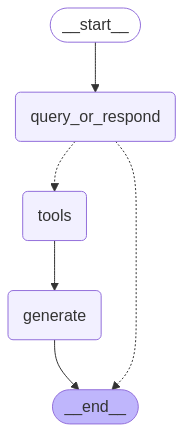

In [12]:
memory = MemorySaver()
graph_builder = StateGraph(MessagesState)
tools = ToolNode([retrieve, load_company_reviews, load_company_welfare, load_company_news])

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges("query_or_respond", tools_condition, {END:END, "tools":"tools"})
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Run

In [13]:
config = {"configurable": {"thread_id": "test_00"}}

target_name = "한미약품"
workstyle_keywords = [
    "전문가형", "역할중심형", "분석형", "겸손형", "논리형",
    "조율자형", "조력자형", "협력형", "마당발형", "과정주의형",
    "몰입형", "일중심사고형", "성취형", "도전형", "자기확신형",
    "혁신형", "창조형", "열린사고형", "직관형", "책임형",
    "열정형", "솔선수범형", "스피드형", "효율형", "신뢰형",
    "유니크형", "윤리형", "끈기형", "목표지향형", "긍정형"
]

In [14]:
# 1단계: 키워드 정의 요청
input_message = f"""{target_name}라는 회사의 업무 방식 또는 기업 문화와 관련된 문서들을 '벡터 데이터베이스'에서 '검색'한다.(쿼리에는 {workstyle_keywords[0]} 키워드를 포함하지 않고 대상 기업의 문화나 업무 방식을 파악할 수 있도록 구성.)

검색된 문서들로부터 업무방식(워크스타일) 또는 기업 문화와 관련된 내용들 중 {workstyle_keywords[0]}는 어떤 내용으로 제시되고 있는지 파악해서 구체적으로 서술해라.
최소 4가지 이상의 내용을 제시해야 하고, {workstyle_keywords[0]}과 관련되지만 중복을 허용하지 않는다.
"""

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

response_content = step["messages"][-1].content
phase1 = response_content

================================ Human Message =================================

한미약품라는 회사의 업무 방식 또는 기업 문화와 관련된 문서들을 '벡터 데이터베이스'에서 '검색'한다.(쿼리에는 전문가형 키워드를 포함하지 않고 대상 기업의 문화나 업무 방식을 파악할 수 있도록 구성.)

검색된 문서들로부터 업무방식(워크스타일) 또는 기업 문화와 관련된 내용들 중 전문가형는 어떤 내용으로 제시되고 있는지 파악해서 구체적으로 서술해라.
최소 4가지 이상의 내용을 제시해야 하고, 전문가형과 관련되지만 중복을 허용하지 않는다.

================================== Ai Message ==================================

[{'text': '한미약품의 업무 방식과 기업 문화에 대한 정보를 검색하고, 전문가형과 관련된 내용을 파악해보겠습니다.\n\n먼저 한미약품의 업무 방식과 기업 문화에 관한 정보를 검색하겠습니다.', 'type': 'text'}, {'id': 'toolu_01Tj8f53NR8LJ2djHrxAJKLo', 'input': {'query': '한미약품 업무 방식 기업 문화'}, 'name': 'retrieve', 'type': 'tool_use'}]
Tool Calls:
  retrieve (toolu_01Tj8f53NR8LJ2djHrxAJKLo)
 Call ID: toolu_01Tj8f53NR8LJ2djHrxAJKLo
  Args:
    query: 한미약품 업무 방식 기업 문화
================================= Tool Message =================================
Name: retrieve

Source: {'company_name': '한미약품', 'url': 'https://hanmi.co.kr/about/responsibili/ethicalMgmt.hm', 'original

In [15]:
input_message = f"""
[지시사항]
{workstyle_keywords[0]}와 {target_name}에서 임직원들에게 제공하는 복지 정보를 데이터베이스에서 로드하여 이전 단계에서 정의한 내용과 복지 정보들을 서로 연관지어 설명해라.
  - 아래는 두 가지 예시이다.
    * '전문가형'이 핵심인 기업은 직원들의 전문성 향상을 위해 다양한 교육 프로그램을 제공한다.
    * '역할중심형'이 핵심인 기업은 직원들이 언제 어디서 근무하든 최적의 컨디션으로 업무에 임할 수 있도록 자율출퇴근이나 재택근무 제도를 제공한다.

[출력형식]
- 각 기준에 대한 답을 구한 뒤, 모든 답을 종합한 하나의 문장형태로 서술해라.
- 답변은 반드시 한국어로 하고, 3000자 이내로 제공해야 한다.
"""

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

response_content = step["messages"][-1].content
phase2 = response_content

================================ Human Message =================================


[지시사항]
전문가형와 한미약품에서 임직원들에게 제공하는 복지 정보를 데이터베이스에서 로드하여 이전 단계에서 정의한 내용과 복지 정보들을 서로 연관지어 설명해라.
  - 아래는 두 가지 예시이다.
    * '전문가형'이 핵심인 기업은 직원들의 전문성 향상을 위해 다양한 교육 프로그램을 제공한다.
    * '역할중심형'이 핵심인 기업은 직원들이 언제 어디서 근무하든 최적의 컨디션으로 업무에 임할 수 있도록 자율출퇴근이나 재택근무 제도를 제공한다.

[출력형식]
- 각 기준에 대한 답을 구한 뒤, 모든 답을 종합한 하나의 문장형태로 서술해라.
- 답변은 반드시 한국어로 하고, 3000자 이내로 제공해야 한다.

================================== Ai Message ==================================

[{'text': '한미약품의 복지 정보를 확인하기 위해 데이터베이스에서 관련 정보를 로드하겠습니다.', 'type': 'text'}, {'id': 'toolu_01MJXykjgX8hgRcGQmf4cxoB', 'input': {'target_name': '한미약품'}, 'name': 'load_company_welfare', 'type': 'tool_use'}]
Tool Calls:
  load_company_welfare (toolu_01MJXykjgX8hgRcGQmf4cxoB)
 Call ID: toolu_01MJXykjgX8hgRcGQmf4cxoB
  Args:
    target_name: 한미약품
회사명: 한미약품, 사업자번호: 124-87-00613
한미약품 복지 3개
================================= Tool Message =================================
Name: load_company_welf

In [16]:
input_message = f"""
[지시사항]
{target_name}에 근무 중이거나 근무했던 직원들의 후기(리뷰)를 데이터베이스에서 로드하고 전체적인 장점, 단점을 정리하여 문장형태로 서술해라.

[출력형식]
- 각 질문에 대한 답을 구한 뒤, 모든 답을 종합한 하나의 문장형태로 서술해라.
- 답변은 반드시 한국어로 작성한다.
"""

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

response_content = step["messages"][-1].content
phase3 = response_content

================================ Human Message =================================


[지시사항]
한미약품에 근무 중이거나 근무했던 직원들의 후기(리뷰)를 데이터베이스에서 로드하고 전체적인 장점, 단점을 정리하여 문장형태로 서술해라.

[출력형식]
- 각 질문에 대한 답을 구한 뒤, 모든 답을 종합한 하나의 문장형태로 서술해라.
- 답변은 반드시 한국어로 작성한다.

================================== Ai Message ==================================

[{'text': '한미약품 직원들의 후기를 데이터베이스에서 로드하여 장점과 단점을 분석해보겠습니다.', 'type': 'text'}, {'id': 'toolu_016v5hmvDDv35aq14xVK2kmx', 'input': {'target_name': '한미약품'}, 'name': 'load_company_reviews', 'type': 'tool_use'}]
Tool Calls:
  load_company_reviews (toolu_016v5hmvDDv35aq14xVK2kmx)
 Call ID: toolu_016v5hmvDDv35aq14xVK2kmx
  Args:
    target_name: 한미약품
회사명: 한미약품, 사업자번호: 124-87-00613
한미약품 리뷰 142개
================================= Tool Message =================================
Name: load_company_reviews

회사명: 한미약품
사업자번호: 124-87-00613

###기업리뷰
[리뷰 1]
- 직무: 생산/제조
- 재직 상태: 전직원
- 지역: 경기
- 작성일: 2025.03
- 평점: 4.0
- 제목: 팀마다 다르겠지만 분위기 좋은팀은 굉장히 좋음 많이 배울 수 있음
- 장점: 장점
팀원과 협업하고 마음이 맞아 재밌게 일할 

In [17]:
input_message = f"""{target_name}이라는 기업에 대한 {workstyle_keywords[0]}이라는 워크스타일과 복지 정보 그리고 실제로 근무했던 임직원들의 리뷰를 바탕으로 다음과 같은 세 가지 결론이 도출되었다.
  1.{target_name}의 {workstyle_keywords[0]} 정의
  {phase1}
  2.{target_name}이 {workstyle_keywords[0]}를 위해 임직원들에게 제공한 복지
  {phase2}
  3. {target_name}에 근무했던 직원들의 경험담
  {phase3}

이러한 결론과 실제 문서 내용을 기반으로 해당 기업에게 {workstyle_keywords[0]}이라는 키워드가 어느 정도로 중요한 워크스타일인지 묻는 질의와 채점 기준을 다음 단계에 따라 정의해라.
이를 참고하면서 다음 단계에 따라 평가 질의와 채점 기준을 정의해라. 마지막 단계에서 [템플릿]에 따라 만든 내용만 출력하고, 중간 단계에서 생성한 값이나 다른 말은 절대 하지 않는다.

[1단계]
- 실제 문서 내용과 추론을 통해 얻은 결론들을 기준으로 제시할 수 있는 질의를 정의한다.
- 질의는 무작정 생성하는게 아니라 문서 내용들을 참고했을 때 채점할 수 있는가를 고려해서 정의해야 한다.
- 최소 4가지 이상의 질의를 정의해야 한다.
- 각 질의별로 중요도(가중치)를 고려해야 한다.

[2단계]
- 각 질의별로 정량적 채점 기준을 정의한다.
- 채점 기준은 0~5점 사이의 정수로 정의되어야 한다.
- 채점 기준은 문서 내용으로부터 제시할 수 있는 사실기반, 수치 등의 구체적인 내용이어야 한다.

[3단계]
아래 제시된 [템플릿]에 따라 평가 질의와 채점 기준을 정의하고 이를 출력한다.
    
    [템플릿]
    1. **평가기준 제목**
    - [평가기준]
        * 상세한 평가기준 내용
        * 현재 평가기준에 적용될 가중치(중요도).

    - [채점기준]
        * 상세한 채점기준 내용
        * 어떠한 기준을 충족하면 어떤 점수를 부여할 것인지 정량적인 기준이 제시어야 함.
        * 충족 기준은 '매우 많고', '적고' 와 같은 추상적인 표현이 아니라 문서 내용으로부터 제시할 수 있는 사실기반, 수치 등의 구체적인 내용이어야 함.

    ### 최종 점수 산출 방법
    1. 각 평가 기준별로 1~5점 배점 후 가중치 적용:
    - (기준1 점수 × 0.25) + (기준2 점수 × 0.25) + (기준3 점수 × 0.25) + (기준4 점수 × 0.25)
    2. 각 단계별 추론 과정을 바탕으로 산출된 점수를 합산하여 최종 점수를 소수점 첫째 자리까지 표기 (예: 4.2).        
 
"""

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

response_content = step["messages"][-1].content

================================ Human Message =================================

한미약품이라는 기업에 대한 전문가형이라는 워크스타일과 복지 정보 그리고 실제로 근무했던 임직원들의 리뷰를 바탕으로 다음과 같은 세 가지 결론이 도출되었다.
  1.한미약품의 전문가형 정의
  # 한미약품의 업무 방식 및 기업 문화 특징

제공된 문서를 분석한 결과, 한미약품의 업무 방식과 기업 문화에서 다음과 같은 특징들을 확인할 수 있습니다:

## 1. 윤리경영 중심의 기업 문화
한미약품은 윤리경영을 핵심 가치로 삼고 있습니다. 임직원들은 윤리규범을 준수하며, 회사는 국내 최초로 공정거래위원회 CP등급 'AAA' 최고 등급을 획득했습니다. 윤리경영은 단순한 구호가 아닌 실천적 가치로, 임직원들의 "변치 않는 마음"을 통해 지속적으로 유지되고 있습니다.

## 2. 혁신 지향적 R&D 문화
한미약품은 "더 좋은 의약품을 우리 기술로 만들자"는 창업자의 신념을 바탕으로 혁신을 추구합니다. 매출액의 15% 이상을 R&D에 투자하며, 한국 최다 혁신신약 파이프라인을 보유하고 있습니다. 이러한 R&D 중심 문화는 "남들이 가지 않는 길"을 개척하는 선도적 정신으로 이어집니다.

## 3. 인간존중 기반의 업무 환경
한미약품의 경영이념인 "인간존중"은 업무 환경에서도 실천됩니다. 임직원들은 서로를 존중하고 건전한 조직 분위기를 조성하기 위해 노력합니다. 직장 내 성희롱, 괴롭힘, 차별 등을 금지하고, 상호 신뢰와 원활한 의사소통을 바탕으로 공존공영의 조직문화를 추구합니다.

## 4. 투명하고 책임감 있는 의사결정 체계
한미약품은 합리적이고 투명한 의사결정 문화를 갖추고 있습니다. 독립적이면서도 객관적인 책임 경영과 선제적인 리스크 관리 역량을 통해 지속가능한 성장을 이루고 있습니다. 이러한 거버넌스는 고객과 주주, 소비자 모두에게 신뢰를 주는 기반이 됩니다.

## 5. 협력과 소통 중심의 업무 방식
한미약품은 동료 및 